## Imports

In [36]:
import pathlib
import PIL.Image
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import splitfolders

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Read Image Data

In [37]:
#Set data directory
data_dir = pathlib.Path('data-no-trash')

In [38]:
#show number of images included in directory
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

2390


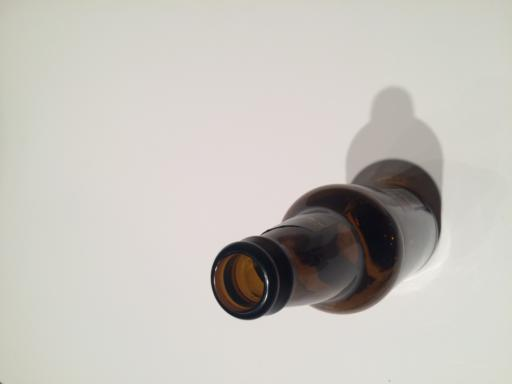

In [39]:
#Display a sample glass image
glass = list(data_dir.glob('glass/*'))
PIL.Image.open(str(glass[0]))

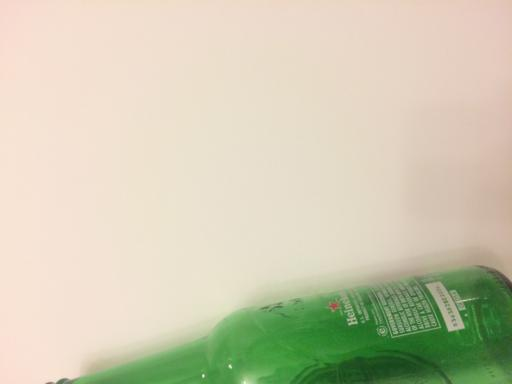

In [40]:
#Display another sample glass image
PIL.Image.open(str(glass[1]))

## Load Dataset

In [41]:
#Define some parameters for the loader:
batch_size = 32
img_height = 384
img_width = 512

#TODO: Resize to smaller size

In [42]:
def train_test_split_folders(data_dir):
    splitfolders.ratio(data_dir, output="images", seed=1337, ratio=(.8, 0.1,0.1))
    image_dir = 'images'

    #create training split  
    train_ds = tf.keras.utils.image_dataset_from_directory(
    image_dir + '/train',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

    #create validation split
    val_ds = tf.keras.utils.image_dataset_from_directory(
    image_dir + '/val',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

    #create validation split
    test_ds = tf.keras.utils.image_dataset_from_directory(
    image_dir + '/test',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = train_test_split_folders(data_dir=data_dir)

Copying files: 2390 files [00:02, 962.06 files/s] 


Found 1910 files belonging to 5 classes.
Found 238 files belonging to 5 classes.
Found 242 files belonging to 5 classes.


In [43]:
#Show names of the found classes
class_names = train_ds.class_names
print(class_names)

['cardboard', 'glass', 'metal', 'paper', 'plastic']


## Configure the dataset

*Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:*

    - Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
    
    - Dataset.prefetch overlaps data preprocessing and model execution while training.

*Interested readers can learn more about both methods, as well as how to cache data to disk in the Prefetching section of the Better performance with the tf.data API guide.*

## Standardize the data

In [44]:
# intializing rescaling layer to map onto data in the next step
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [45]:
# creating the normalized dataset
 
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in '[0, 1]'
print(np.min(first_image), np.max(first_image))

0.058823533 0.92549026


In [46]:
AUTOTUNE = tf.data.AUTOTUNE

#load data into cache to reduce i/o
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [47]:
num_classes = len(class_names)

model = tf.keras.Sequential(
    [
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
    ]
)

In [48]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [49]:
history = model.fit(
    train_ds,
    validation_data=val_ds, 
    epochs=10
)

Epoch 1/10
60/60 [==============================] - 328s 5s/step - loss: 1.7200 - accuracy: 0.3728 - val_loss: 1.3097 - val_accuracy: 0.4328
Epoch 2/10
60/60 [==============================] - 301s 5s/step - loss: 1.1309 - accuracy: 0.5393 - val_loss: 1.2459 - val_accuracy: 0.5126
Epoch 3/10
60/60 [==============================] - 299s 5s/step - loss: 0.9994 - accuracy: 0.5932 - val_loss: 1.2408 - val_accuracy: 0.5420
Epoch 4/10
60/60 [==============================] - 301s 5s/step - loss: 0.7647 - accuracy: 0.7194 - val_loss: 1.2184 - val_accuracy: 0.5546
Epoch 5/10
60/60 [==============================] - 408s 7s/step - loss: 0.5508 - accuracy: 0.7953 - val_loss: 1.2725 - val_accuracy: 0.6008
Epoch 6/10
60/60 [==============================] - 300s 5s/step - loss: 0.3708 - accuracy: 0.8712 - val_loss: 1.5103 - val_accuracy: 0.5924
Epoch 7/10
60/60 [==============================] - 296s 5s/step - loss: 0.2679 - accuracy: 0.9178 - val_loss: 1.8166 - val_accuracy: 0.5672
Epoch 8/10
60

In [50]:
#export training history
save = False

if save:
    np.save('test2_history.npy',history.history)

In [51]:
history = history.history

In [52]:
#import training history
load = False

if load:
    history=np.load('my_history.npy',allow_pickle='TRUE').item()

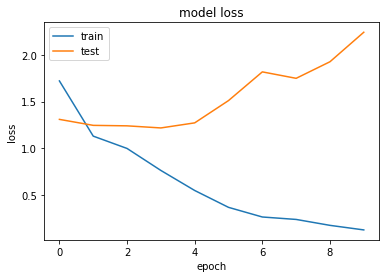

In [53]:
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

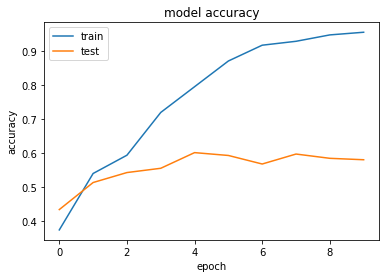

In [54]:
# summarize history for accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [55]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

NameError: name 'predictions' is not defined

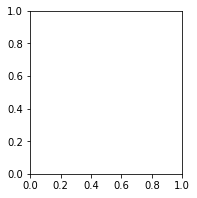

In [56]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

In [ ]:
# TODO: Tensorboard
# TODO: Predict Sample image
# TODO: Model Optimizer implementieren (KERAS Tuner)